In [135]:
import pprint

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX # будем использовать SARIMAX а не ARIMA тк у нас датасет с явно выраженной сезонностью

df = pd.read_csv("../ts_hw_1/Series/international-airline-passengers.csv")

In [136]:
pprint.pp(df.head())

     Month  Count
0  1949-01    112
1  1949-02    118
2  1949-03    132
3  1949-04    129
4  1949-05    121


In [137]:
ts = df['Count']
ts.index = pd.to_datetime(df['Month'])

def sarima_forecast(time_series, seasonal=True, m=12, steps=12, log_transform=True):
    y = time_series.copy()

    if log_transform:
        y = np.log(y)

    model_auto = auto_arima(
        y,
        seasonal=seasonal,
        m=m,
        freq='MS',
        stepwise=True,
        suppress_warnings=True,
        error_action="ignore",
        trace=True
    )

    sarima_model = SARIMAX(
        y,
        order=model_auto.order,
        seasonal_order=model_auto.seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fit_model = sarima_model.fit(disp=False)

    forecast_obj = fit_model.get_forecast(steps=steps)
    fcst_mean = forecast_obj.predicted_mean
    fcst_ci = forecast_obj.conf_int()

    if log_transform:
        fcst_mean = np.exp(fcst_mean)
        fcst_ci = np.exp(fcst_ci)
        residuals = fit_model.resid
    else:
        residuals = fit_model.resid

    return fcst_mean, fcst_ci, residuals, fit_model

In [138]:
fcst_mean, fcst_ci, residuals_log, model_log = sarima_forecast(ts, seasonal=True, m=12, steps=12, log_transform=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1020.048, Time=0.36 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.05 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1019.935, Time=0.23 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1019.290, Time=0.06 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1019.546, Time=0.20 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1024.160, Time=0.03 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1017.847, Time=0.05 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1017.914, Time=0.19 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1018.359, Time=0.18 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1018.248, Time=0.36 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.02 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.393, Time=0.02 sec
 ARIMA(3,1,1)(0,1,0

/Users/eugene_ivanov/PycharmProjects/ds_python/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eugene_ivanov/PycharmProjects/ds_python/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


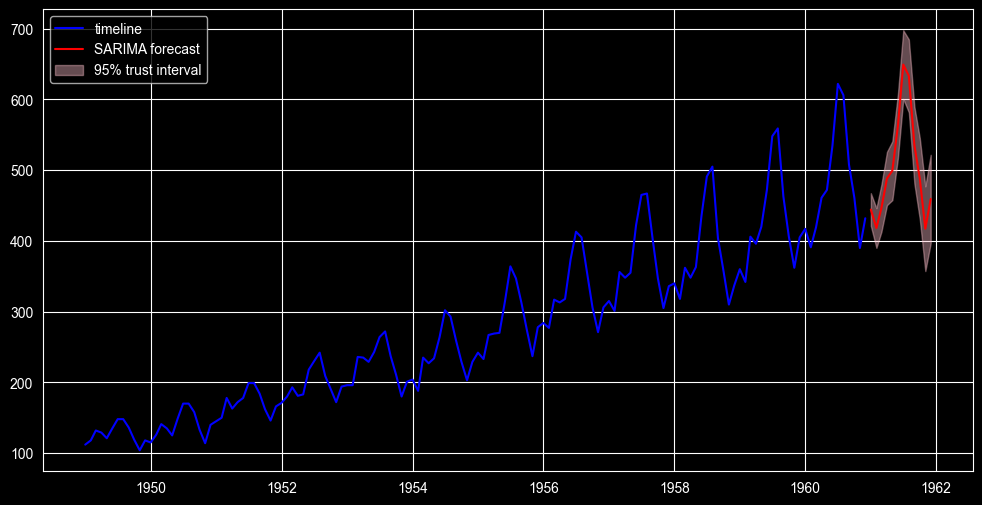

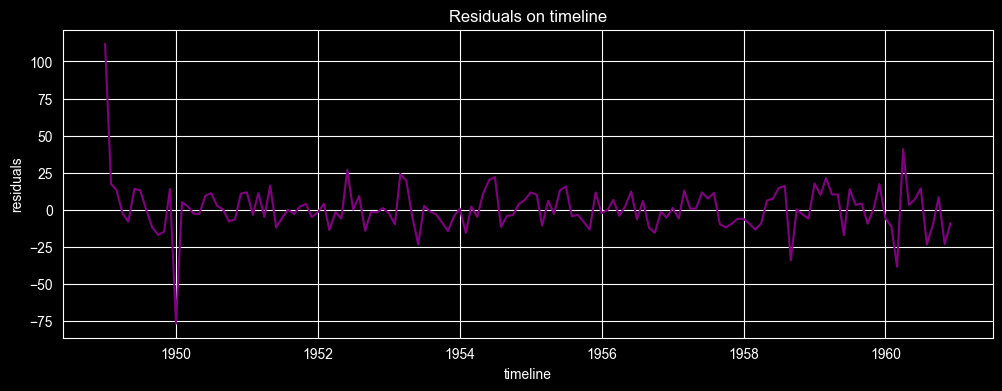

In [139]:
plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts, label='timeline', color='blue')
plt.plot(fcst_mean.index, fcst_mean, label='SARIMA forecast', color='red')
plt.fill_between(
    fcst_ci.index,
    fcst_ci.iloc[:, 0],
    fcst_ci.iloc[:, 1],
    color='pink', alpha=0.4, label='95% trust interval'
)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(residuals_log, color='purple')
plt.title('Residuals on timeline')
plt.xlabel('timeline')
plt.ylabel('residuals')
plt.grid(True)
plt.show()

In [140]:
# исходя из вывода по остаткам - они похожи на белый шум, поэтому проводить логарифмическое преобразование нецелесообразно